In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import shap
shap.initjs()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AUC: 0.6105902151700926
F1 Score: 0.8106312292358804


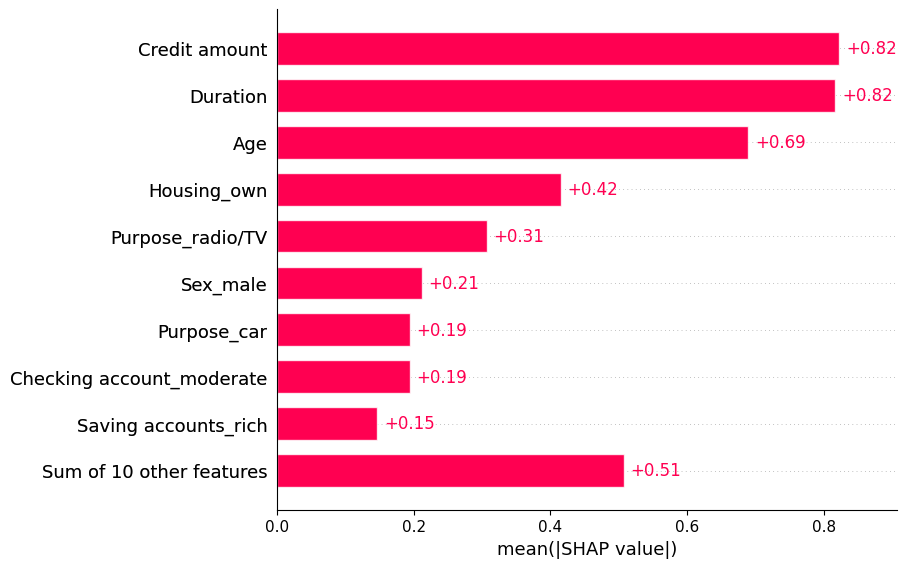

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import shap
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/german_credit_data.csv')

# Drop 'Unnamed: 0' column if it's an index artifact
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Encode the target variable 'Risk'
le = LabelEncoder()
df['Risk'] = le.fit_transform(df['Risk'])

X = df.drop('Risk', axis=1)
y = df['Risk']

# Identify categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Convert any remaining boolean columns to integer (0 or 1) for SHAP compatibility
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
# With one-hot encoding, features are numerical, so enable_categorical is not needed.
# use_label_encoder is deprecated, so removing it.
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("AUC:", roc_auc_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Global importance
shap.plots.bar(shap_values)

# Local force plots
shap.plots.force(shap_values[0])  # high risk
shap.plots.force(shap_values[10]) # low risk
shap.plots.force(shap_values[20]) # borderline

In [10]:
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_importance)


                        Feature  Importance
3                      Duration      0.0965
2                 Credit amount      0.0785
0                           Age      0.0440
10    Checking account_moderate      0.0230
5                   Housing_own      0.0175
6                  Housing_rent      0.0150
9          Saving accounts_rich      0.0100
4                      Sex_male      0.0070
14            Purpose_education      0.0050
8    Saving accounts_quite rich      0.0045
11        Checking account_rich      0.0035
12                  Purpose_car      0.0020
17              Purpose_repairs      0.0000
18      Purpose_vacation/others      0.0000
13  Purpose_domestic appliances      0.0000
16             Purpose_radio/TV     -0.0005
1                           Job     -0.0010
7      Saving accounts_moderate     -0.0060
15  Purpose_furniture/equipment     -0.0070


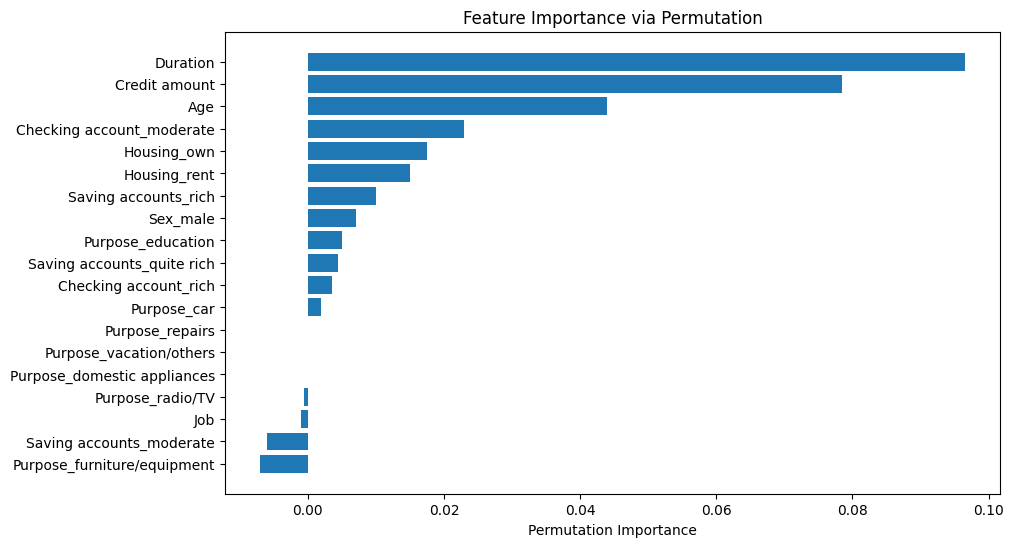

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(perm_importance['Feature'], perm_importance['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation')
plt.gca().invert_yaxis()
plt.show()


In [12]:
sample = X_test.iloc[0].copy()
original_pred = model.predict_proba([sample])[0][1]

# Change Duration
sample['Duration'] = sample['Duration'] * 0.5
new_pred = model.predict_proba([sample])[0][1]

print("Original Prediction:", original_pred)
print("New Prediction after Duration change:", new_pred)


Original Prediction: 0.9933289
New Prediction after Duration change: 0.9822062


In [16]:
import matplotlib.pyplot as plt
import os

# Create the directory if it doesn't exist
output_dir = "visuals"
os.makedirs(output_dir, exist_ok=True)

# Example: save bar plot
shap.plots.bar(shap_values, show=False)
plt.savefig(os.path.join(output_dir, "shap_bar.png"), dpi=300, bbox_inches='tight')
plt.close()

# Example: save permutation importance plot
plt.figure(figsize=(10,6))
plt.barh(perm_importance['Feature'], perm_importance['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation')
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "permutation_importance.png"), dpi=300, bbox_inches='tight')
plt.close()

In [15]:
shap.initjs()
shap.save_html("visuals/shap_force_highrisk.html", shap.plots.force(shap_values[0]))


In [17]:
import shap

# Initialize JS for interactive plots
shap.initjs()

# High risk case
shap.save_html("visuals/shap_force_highrisk.html", shap.plots.force(shap_values[0]))

# Low risk case
shap.save_html("visuals/shap_force_lowrisk.html", shap.plots.force(shap_values[10]))

# Borderline case
shap.save_html("visuals/shap_force_borderline.html", shap.plots.force(shap_values[20]))


In [18]:
import matplotlib.pyplot as plt

sample = X_test.iloc[0].copy()
original_pred = model.predict_proba([sample])[0][1]

# Change Duration
sample['Duration'] = sample['Duration'] * 0.5
new_pred = model.predict_proba([sample])[0][1]

# Plot sensitivity
plt.bar(['Original', 'Modified'], [original_pred, new_pred], color=['blue','red'])
plt.ylabel("Predicted Risk Probability")
plt.title("SHAP Sensitivity: Effect of Duration Change")
plt.savefig("visuals/shap_sensitivity.png", dpi=300, bbox_inches='tight')
plt.close()


In [20]:
from google.colab import files
files.download("shap_force_highrisk.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from google.colab import files
files.download("shap_force_lowrisk.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from google.colab import files
files.download("shap_force_borderline.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt

# Pick one sample from test set
sample = X_test.iloc[0].copy()
original_pred = model.predict_proba([sample])[0][1]

# Modify a key feature (Duration)
sample_modified = sample.copy()
sample_modified['Duration'] = sample_modified['Duration'] * 0.5   # reduce duration
new_pred = model.predict_proba([sample_modified])[0][1]

# Plot sensitivity
plt.figure(figsize=(6,4))
plt.bar(['Original', 'Modified'], [original_pred, new_pred], color=['blue','red'])
plt.ylabel("Predicted Risk Probability")
plt.title("SHAP Sensitivity: Effect of Duration Change")
plt.savefig("visuals/shap_sensitivity.png", dpi=300, bbox_inches='tight')
plt.close()

print("Original Prediction:", original_pred)
print("New Prediction after Duration change:", new_pred)


Original Prediction: 0.9933289
New Prediction after Duration change: 0.9822062


In [24]:
from google.colab import files
files.download("visuals/shap_sensitivity.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>